In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler, LabelEncoder
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    precision_recall_curve
)
import xgboost as xgb
import shap
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold

c:\Users\parvr\anaconda3\envs\fintech\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df=pd.read_csv('../data/final/Classification_table.csv')

In [5]:
df.shape

(264909, 44)

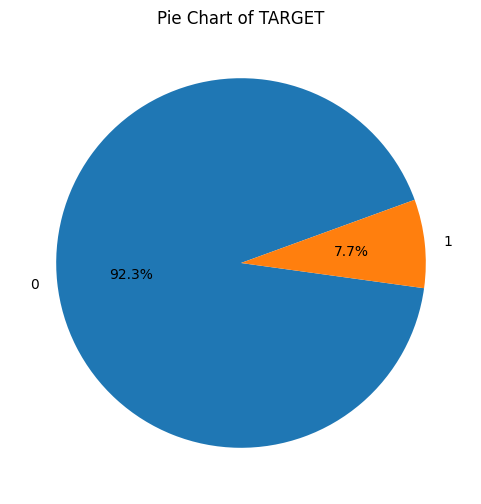

In [6]:
value_counts = df["TARGET"].value_counts()
top_n = 6
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
pie_data = value_counts.head(top_n)
axes.pie(
    pie_data,
    labels=pie_data.index.tolist(),
    autopct='%1.1f%%',
    startangle=20
)
axes.set_title('Pie Chart of TARGET')
plt.show()

In [7]:
final_features_classification = [

    # numeric (raw / ratios)
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',

    'Credit_to_Income_Ratio',
    'Annuity_to_Income_Ratio',
    'Annuity_to_Credit_Ratio',

    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',

    'REGION_POPULATION_RELATIVE',
    'DAYS_BIRTH',
    'DAYS_REGISTRATION',
    'DAYS_LAST_PHONE_CHANGE',
    'CNT_FAM_MEMBERS',
    'REGION_RATING_CLIENT',

    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',

    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_YEAR',

    'bureau_overdue_months',
    'total_active_bureau_loans',

    'pos_num_loans',
    'pos_mean_cnt_instalment',

    'inst_mean_payment_delay',
    'inst_mean_payment_rate',

    'avg_prev_amt_requested',
    'prev_num_approved',
    'prev_num_rejected',

    'max_cc_sk_dpd_def',
    'CC_PAYMENT_RATIO',
    'DELINQUENCY_SEVERITY',

    # binary flags
    'HAS_CC_DELINQUENCY',
    'NO_CC_PAYMENT_FLAG',

    # categorical (encode later)
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',

    # target
    'TARGET'
]


In [8]:
y = df['TARGET']
X = df.drop(columns=['TARGET'])

In [9]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
num_cols = X.select_dtypes(include=['number','int64','float64']).columns

Logistic Regression (baseline)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_val_cat = ohe.transform(X_val[cat_cols])

In [12]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_val_num = scaler.transform(X_val[num_cols])

In [13]:
X_train_final = pd.concat([
    pd.DataFrame(np.asarray(X_train_num), index=X_train.index),
    pd.DataFrame(np.asarray(X_train_cat), index=X_train.index)
], axis=1)

X_val_final = pd.concat([
    pd.DataFrame(np.asarray(X_val_num), index=X_val.index),
    pd.DataFrame(np.asarray(X_val_cat), index=X_val.index)
], axis=1)

In [14]:
model1 = LogisticRegression(max_iter=1000, class_weight='balanced')

In [15]:
mlflow.set_experiment("Target_Classification")
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run():
    model1.fit(X_train_final, y_train)

    preds = model1.predict_proba(X_val_final)[:,1]

    # metrics
    roc_auc = roc_auc_score(y_val, preds)
    pr_auc = average_precision_score(y_val, preds)
    precision = precision_score(y_val, model1.predict(X_val_final))
    recall = recall_score(y_val, model1.predict(X_val_final))
    f1 = f1_score(y_val, model1.predict(X_val_final))
    accuracy = accuracy_score(y_val, model1.predict(X_val_final))
    fpr, tpr, _ = roc_curve(y_val, preds)
    ks = np.max(tpr - fpr)

    mlflow.log_param("model_type", "LogesticRegression")
    mlflow.log_param("features_count", X.shape[1])

    mlflow.log_metric("roc_auc", float(roc_auc))
    mlflow.log_metric("pr_auc", float(pr_auc))
    mlflow.log_metric("precision", float(precision))
    mlflow.log_metric("recall", float(recall))
    mlflow.log_metric("f1", float(f1))
    mlflow.log_metric("accuracy", float(accuracy))
    mlflow.log_metric("ks_statistic", float(ks))

    mlflow.sklearn.log_model(
        model1,
        artifact_path="model"
    )


2025/12/17 18:27:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/17 18:27:36 INFO mlflow.store.db.utils: Updating database tables
2025/12/17 18:27:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 18:27:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 18:27:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run worried-gnu-979 at: http://127.0.0.1:5000/#/experiments/2/runs/ab0cf2bf9358494492fcf08f5ff049d0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


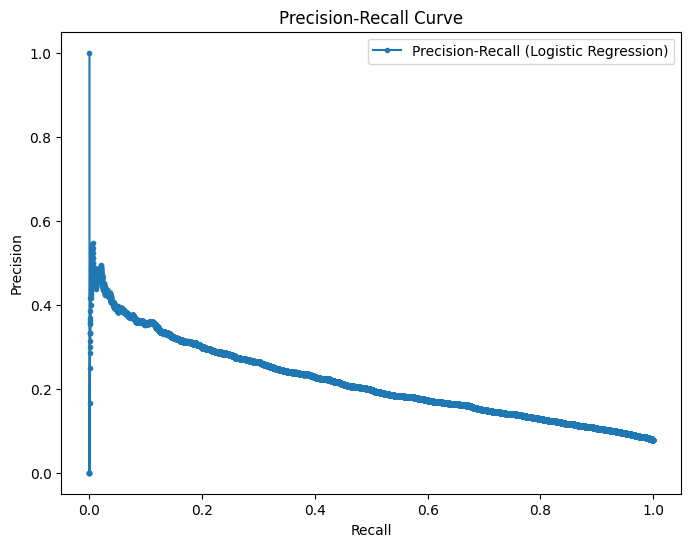

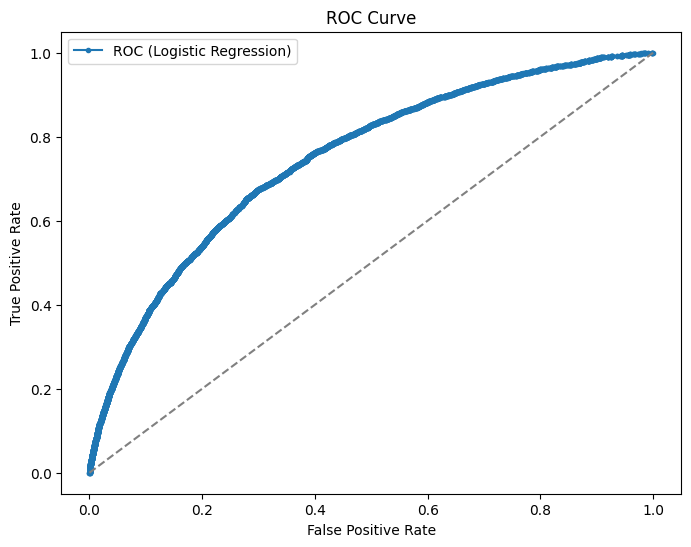

In [16]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC (Logistic Regression)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

XGBOOST

In [6]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
cat_cols = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols)
    ],
    remainder="passthrough"
)

In [9]:
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

In [10]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [11]:
model2 = xgb.XGBClassifier(
    n_estimators=2300,
    learning_rate=0.018,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,   
    reg_lambda=2.0,  
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

In [12]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():

    # train (XGBoost already supports early stopping via eval_set)
    model2.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    # probabilities
    y_proba = model2.predict_proba(X_val)[:, 1]

    # threshold (keep explicit)
    threshold = 0.25
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ks = np.max(tpr - fpr)

    # log params
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks)

    # log model
    mlflow.xgboost.log_model(
        model2,
        artifact_path="model"
    )

[0]	validation_0-auc:0.70193
[100]	validation_0-auc:0.73650
[200]	validation_0-auc:0.75009
[300]	validation_0-auc:0.75671
[400]	validation_0-auc:0.76023
[500]	validation_0-auc:0.76251
[600]	validation_0-auc:0.76400
[700]	validation_0-auc:0.76529
[800]	validation_0-auc:0.76641
[900]	validation_0-auc:0.76730
[1000]	validation_0-auc:0.76788
[1100]	validation_0-auc:0.76842
[1200]	validation_0-auc:0.76873
[1300]	validation_0-auc:0.76923
[1400]	validation_0-auc:0.76961
[1500]	validation_0-auc:0.76990
[1600]	validation_0-auc:0.77005
[1700]	validation_0-auc:0.77019
[1800]	validation_0-auc:0.77040
[1900]	validation_0-auc:0.77048
[2000]	validation_0-auc:0.77040
[2100]	validation_0-auc:0.77057
[2200]	validation_0-auc:0.77057
[2299]	validation_0-auc:0.77054


2025/12/17 18:58:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run redolent-flea-134 at: http://127.0.0.1:5000/#/experiments/2/runs/5d090df111a84fbe99851ce0df7a49be
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


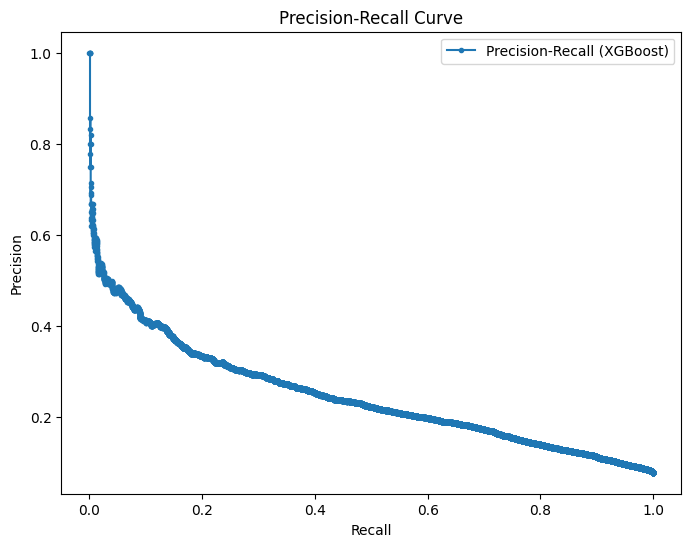

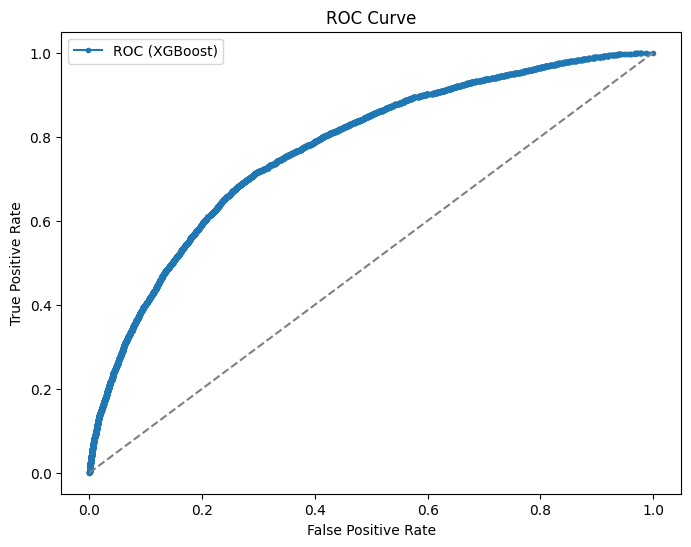

In [13]:
# Precision-Recall Curve for XGBoost
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall (XGBoost)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve for XGBoost
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC (XGBoost)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

LightGBM

In [68]:

def roc_auc_callback(X_val, y_val, log_every=200):
    def _callback(env):
        iteration = env.iteration + 1

        if iteration % log_every == 0:
            # predict probabilities
            y_proba = env.model.predict(X_val, num_iteration=iteration)

            auc = roc_auc_score(y_val, y_proba)

            print(f"[Iter {iteration}] ROC-AUC: {auc:.5f}")

            # log to mlflow with step
            mlflow.log_metric("val_roc_auc", auc, step=iteration)

    return _callback

In [44]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']

In [45]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
cat_cols = X_train.select_dtypes(include=['object','category']).columns

label_encoders = {}

for col in cat_cols:
    # ensure string
    X_train[col] = X_train[col].astype(str)
    X_val[col]   = X_val[col].astype(str)

    # most frequent category from TRAIN only (no leakage)
    most_freq = X_train[col].mode()[0]

    # fill missing
    X_train[col] = X_train[col].fillna(most_freq)
    X_val[col]   = X_val[col].fillna(most_freq)

    # fit encoder on train
    le = LabelEncoder()
    le.fit(X_train[col])

    # map unseen categories in validation to most frequent
    X_val[col] = X_val[col].apply(
        lambda x: x if x in le.classes_ else most_freq
    )

    # transform
    X_train[col] = le.transform(X_train[col])
    X_val[col]   = le.transform(X_val[col])

    label_encoders[col] = le

In [89]:
model3 = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",

    # learning
    n_estimators=3500,
    learning_rate=0.003,     

    # tree structure
    num_leaves=128,           
    max_depth=-1,
    min_child_samples=150,     
    min_split_gain=0.0,     

    # regularization (light, not heavy)
    reg_alpha=0.0,
    reg_lambda=1.0,

    # sampling
    subsample=0.9,
    subsample_freq=1,
    colsample_bytree=0.9,

    # imbalance
    scale_pos_weight=scale_pos_weight,

    random_state=42,
    n_jobs=-1
)

In [90]:
assert len(X_train.select_dtypes(include=['object','category']).columns) == 0
assert len(X_val.select_dtypes(include=['object','category']).columns) == 0

In [91]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():
    # train with early stopping
    model3.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[
            roc_auc_callback(X_val, y_val, log_every=200)
        ]
    )
    y_proba = model3.predict_proba(
        X_val,
        num_iteration=model3.best_iteration_
    )
    y_proba = y_proba[:, 1]

    # explicit threshold
    threshold = 0.05
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    ks = np.max(tpr - fpr)

    # log params
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)

    model_params = model3.get_params()
    for param_name, param_value in model_params.items():
        mlflow.log_param(f"lgbm_{param_name}", param_value)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks)

    # log model
    mlflow.lightgbm.log_model(
        model3,
        artifact_path="model"
    )
print("Positive predictions:", y_pred.sum())
print("Mean proba:", y_proba.mean())
print("Max proba:", y_proba.max())


[LightGBM] [Info] Number of positive: 16392, number of negative: 195535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4897
[LightGBM] [Info] Number of data points in the train set: 211927, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077347 -> initscore=-2.478946
[LightGBM] [Info] Start training from score -2.478946
[Iter 200] ROC-AUC: 0.74984
[Iter 400] ROC-AUC: 0.75386
[Iter 600] ROC-AUC: 0.75718
[Iter 800] ROC-AUC: 0.76019
[Iter 1000] ROC-AUC: 0.76279
[Iter 1200] ROC-AUC: 0.76498
[Iter 1400] ROC-AUC: 0.76652
[Iter 1600] ROC-AUC: 0.76781
[Iter 1800] ROC-AUC: 0.76870
[Iter 2000] ROC-AUC: 0.76945
[Iter 2200] ROC-AUC: 0.76989
[Iter 2400] ROC-AUC: 0.77019
[Iter 2600] ROC-AUC: 0.77052
[Iter 2800] ROC-AUC: 0.77074
[Iter 3000] ROC-AUC: 0.77089
[Iter 3200] ROC-AUC: 0.77099
[Iter 3400] ROC-AUC: 0.77098


2025/12/17 20:10:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run rebellious-sow-86 at: http://127.0.0.1:5000/#/experiments/2/runs/0b2929408cc946c984830a4c71634211
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2
Positive predictions: 51001
Mean proba: 0.3381420974408568
Max proba: 0.9365766489512858


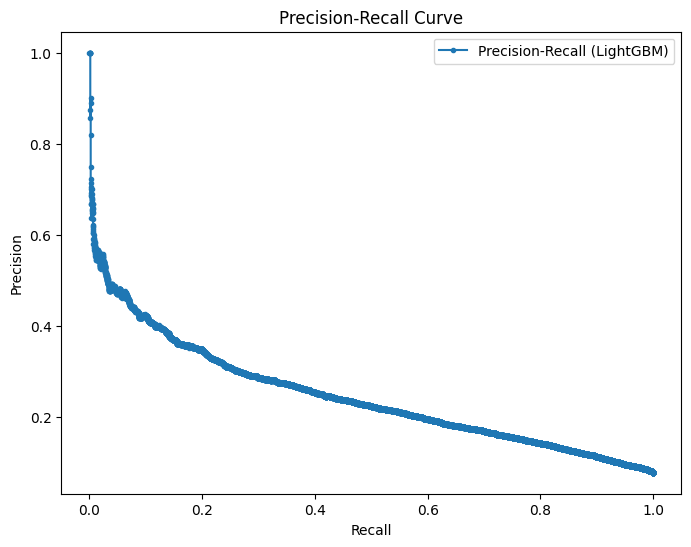

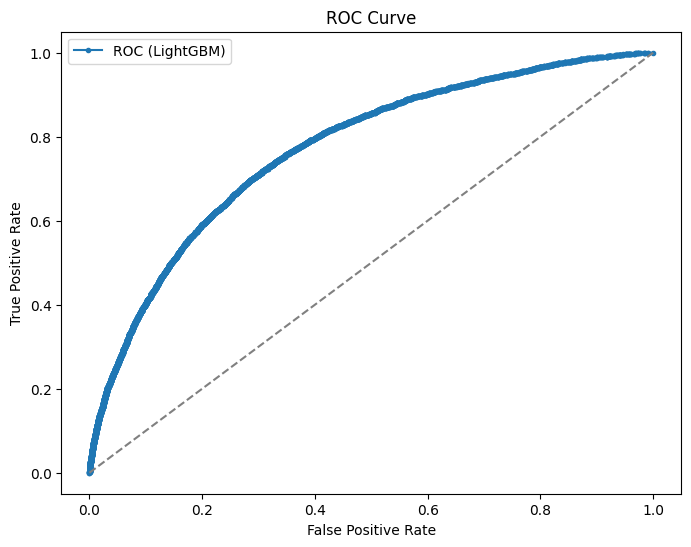

In [92]:
# Precision-Recall Curve for LightGBM
precision, recall, thresholds = precision_recall_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Precision-Recall (LightGBM)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve for LightGBM
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label='ROC (LightGBM)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

AS XGBoost is giving best ROC-AUC It will be final model

In [10]:
X = df.drop(columns=['TARGET'])
y = df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
cat_cols = X_train.select_dtypes(include=['object','category']).columns

label_encoders = {}

for col in cat_cols:
    # ensure string
    X_train[col] = X_train[col].astype(str)
    X_val[col]   = X_val[col].astype(str)

    # most frequent category from TRAIN only (no leakage)
    most_freq = X_train[col].mode()[0]

    # fill missing
    X_train[col] = X_train[col].fillna(most_freq)
    X_val[col]   = X_val[col].fillna(most_freq)

    # fit encoder on train
    le = LabelEncoder()
    le.fit(X_train[col])

    # map unseen categories in validation to most frequent
    X_val[col] = X_val[col].apply(
        lambda x: x if x in le.classes_ else most_freq
    )

    # transform
    X_train[col] = le.transform(X_train[col])
    X_val[col]   = le.transform(X_val[col])

    label_encoders[col] = le

In [12]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [10]:
model5 = xgb.XGBClassifier(
    n_estimators=2300,
    learning_rate=0.018,
    max_depth=4,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,   
    reg_lambda=2.0,  
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

In [101]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():

    # train (XGBoost already supports early stopping via eval_set)
    model5.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    # probabilities
    y_proba = model5.predict_proba(X_val)[:, 1]

       
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    ks_scores = tpr - fpr
    threshold =0.3

    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)


    # log params
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks)

    # log model
    mlflow.xgboost.log_model(
        model5,
        artifact_path="model"
    )

[0]	validation_0-auc:0.62396
[100]	validation_0-auc:0.73724
[200]	validation_0-auc:0.74980
[300]	validation_0-auc:0.75646
[400]	validation_0-auc:0.76002
[500]	validation_0-auc:0.76249
[600]	validation_0-auc:0.76418
[700]	validation_0-auc:0.76598
[800]	validation_0-auc:0.76687
[900]	validation_0-auc:0.76771
[1000]	validation_0-auc:0.76828
[1100]	validation_0-auc:0.76885
[1200]	validation_0-auc:0.76905
[1300]	validation_0-auc:0.76938
[1400]	validation_0-auc:0.76960
[1500]	validation_0-auc:0.76978
[1600]	validation_0-auc:0.76979
[1700]	validation_0-auc:0.76994
[1800]	validation_0-auc:0.77017
[1900]	validation_0-auc:0.77017
[2000]	validation_0-auc:0.77017
[2100]	validation_0-auc:0.77022
[2200]	validation_0-auc:0.77029
[2299]	validation_0-auc:0.77015


2025/12/17 20:52:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run placid-colt-298 at: http://127.0.0.1:5000/#/experiments/2/runs/9dcb5e5da3674c4d89f7c09f4589ef8d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


GridSearchCV

In [103]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

In [106]:
param_grid = {
    "n_estimators": [2300, 2800],
    "learning_rate": [0.01, 0.018, 0.03],
    "max_depth": [ 4, 5],
    "min_child_weight": [3, 5, 8],
    "subsample": [ 0.8],
    "colsample_bytree": [0.8],
    "reg_alpha": [ 1.0],
    "reg_lambda": [2.0]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [107]:
grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="roc_auc",    
    cv=cv,
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8], 'learning_rate': [0.01, 0.018, ...], 'max_depth': [4, 5], 'min_child_weight': [3, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [108]:
best_model = grid.best_estimator_
print("Best ROC-AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

Best ROC-AUC: 0.7734511785800227
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.018, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 2300, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8}


In [13]:
param={'colsample_bytree': 0.8, 'learning_rate': 0.018, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 2300, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'subsample': 0.8}

In [35]:
model6 = xgb.XGBClassifier(**param,objective='binary:logistic',
    eval_metric='auc',
    base_score=0.5000,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1)

In [36]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Target_Classification")

with mlflow.start_run():

    model6.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )

    # probabilities
    y_proba = model6.predict_proba(X_val)[:, 1]

       
    fpr, tpr, thresholds = roc_curve(y_val, y_proba)
    ks_scores = tpr - fpr
    threshold = 0.05

    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    roc_auc = roc_auc_score(y_val, y_proba)
    pr_auc = average_precision_score(y_val, y_proba)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)


    # log params
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("threshold", threshold)

    mlflow.log_param("n_estimators", param["n_estimators"])
    mlflow.log_param("learning_rate", param["learning_rate"])
    mlflow.log_param("max_depth", param["max_depth"])
    mlflow.log_param("min_child_weight", param["min_child_weight"])
    mlflow.log_param("subsample", param["subsample"])
    mlflow.log_param("colsample_bytree", param["colsample_bytree"])
    mlflow.log_param("reg_alpha", param["reg_alpha"])
    mlflow.log_param("reg_lambda", param["reg_lambda"])

    # 3. Log fixed XGBoost parameters
    mlflow.log_param("objective", "binary:logistic")
    mlflow.log_param("eval_metric", "auc")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_jobs", -1)

    # log metrics
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_metric("pr_auc", pr_auc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("ks_statistic", ks_scores.max())

    # log model
    mlflow.xgboost.log_model(
        model6,
        artifact_path="model"
    )

[0]	validation_0-auc:0.62396
[100]	validation_0-auc:0.73724
[200]	validation_0-auc:0.74980
[300]	validation_0-auc:0.75646
[400]	validation_0-auc:0.76002
[500]	validation_0-auc:0.76249
[600]	validation_0-auc:0.76418
[700]	validation_0-auc:0.76598
[800]	validation_0-auc:0.76687
[900]	validation_0-auc:0.76771
[1000]	validation_0-auc:0.76828
[1100]	validation_0-auc:0.76885
[1200]	validation_0-auc:0.76905
[1300]	validation_0-auc:0.76938
[1400]	validation_0-auc:0.76960
[1500]	validation_0-auc:0.76978
[1600]	validation_0-auc:0.76979
[1700]	validation_0-auc:0.76994
[1800]	validation_0-auc:0.77017
[1900]	validation_0-auc:0.77017
[2000]	validation_0-auc:0.77017
[2100]	validation_0-auc:0.77022
[2200]	validation_0-auc:0.77029
[2299]	validation_0-auc:0.77015


2025/12/19 18:49:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run bouncy-whale-363 at: http://127.0.0.1:5000/#/experiments/2/runs/0acfd6df24b04bb8aa83d26c3993d05d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/2


In [13]:
fpr, tpr, thresholds = roc_curve(y_val, y_proba)
ks_scores = tpr - fpr
best_idx = np.argmax(ks_scores)

best_threshold = thresholds[best_idx]
best_ks = ks_scores[best_idx]

best_threshold, best_ks

(np.float32(0.46748844), np.float64(0.41801745062034484))

CrossValidation

In [42]:
cat_cols = X.select_dtypes(include=['object','category']).columns

label_encoders = {}

for col in cat_cols:
    X[col] = X[col].astype(str)
    most_freq = X[col].mode()[0]

    X[col]   = X[col].fillna(most_freq)

    le = LabelEncoder()
    le.fit(X[col])
    X[col] = le.transform(X[col])

    label_encoders[col] = le

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ks_scores = []
recall_scores = []

threshold = 0.05 

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):

    X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBClassifier(
        **grid.best_params_
    )

    model.fit(X_tr, y_tr)

    # probabilities
    y_proba = model.predict_proba(X_va)[:, 1]

    # KS
    fpr, tpr, _ = roc_curve(y_va, y_proba)
    ks = np.max(tpr - fpr)
    ks_scores.append(ks)

    # Recall at fixed threshold
    y_pred = (y_proba >= threshold).astype(int)
    recall = recall_score(y_va, y_pred)
    recall_scores.append(recall)

    print(f"Fold {fold} → KS: {ks:.4f}, Recall: {recall:.4f}")

# Final CV summary
print("\n===== Cross-Validation Results =====")
print(f"KS     : {np.mean(ks_scores):.4f} ± {np.std(ks_scores):.4f}")
print(f"Recall : {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")

Fold 1 → KS: 0.4252, Recall: 0.8280
Fold 2 → KS: 0.3995, Recall: 0.8119
Fold 3 → KS: 0.4174, Recall: 0.8314
Fold 4 → KS: 0.4246, Recall: 0.8270
Fold 5 → KS: 0.4112, Recall: 0.8285

===== Cross-Validation Results =====
KS     : 0.4156 ± 0.0095
Recall : 0.8253 ± 0.0069


In [14]:
run_id = "2f14ab98bd8e46f7a0fa02acc3fae211"
model_uri = f"runs:/{run_id}/model"

mlflow.register_model(
    model_uri=model_uri,
    name="XGBoost_Loan_Default_Classifier"
)


Successfully registered model 'XGBoost_Loan_Default_Classifier'.
2025/12/18 13:36:53 WARNING mlflow.tracking._model_registry.fluent: Run with id 2f14ab98bd8e46f7a0fa02acc3fae211 has no artifacts at artifact path 'model', registering model based on models:/m-bd40d3b5050b4faf808d3b231646c605 instead
2025/12/18 13:36:54 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: XGBoost_Loan_Default_Classifier, version 1
Created version '1' of model 'XGBoost_Loan_Default_Classifier'.


<ModelVersion: aliases=[], creation_timestamp=1766045214274, current_stage='None', deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1766045214274, metrics=None, model_id=None, name='XGBoost_Loan_Default_Classifier', params=None, run_id='2f14ab98bd8e46f7a0fa02acc3fae211', run_link='', source='models:/m-bd40d3b5050b4faf808d3b231646c605', status='READY', status_message=None, tags={}, user_id='', version='1'>

SHAP Explanation

In [39]:
X_shap = X_val.sample(1000, random_state=42)
booster = model6.get_booster()


dmat = xgb.DMatrix(X_shap)

# get SHAP contributions
shap_values = booster.predict(
    dmat,
    pred_contribs=True
)
shap_values = shap_values[:, :-1]

shap_df = pd.DataFrame(
    shap_values,
    columns=X_shap.columns
)

<Axes: >

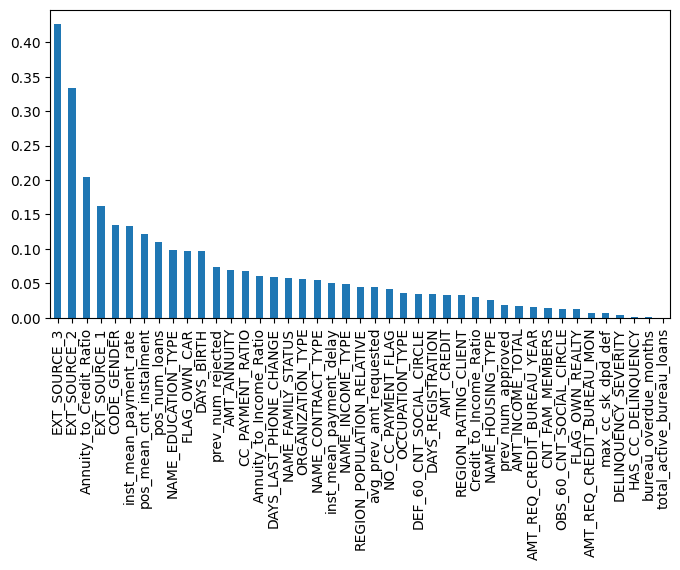

In [40]:
shap_df.abs().mean().sort_values(ascending=False).plot(
    kind="bar",
    figsize=(8, 4)
)


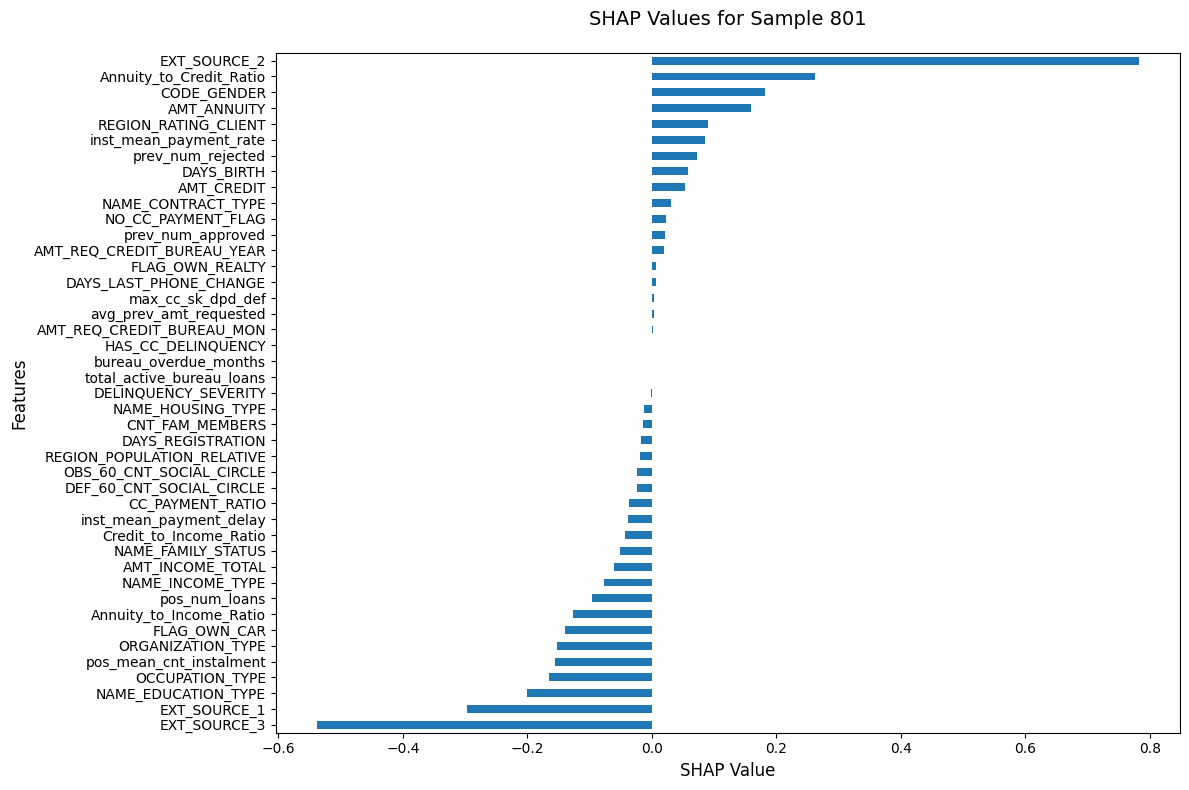

In [42]:
plt.figure(figsize=(12, 8))
shap_df.iloc[801].sort_values().plot(kind="barh")

plt.title(f"SHAP Values for Sample 801", fontsize=14, pad=20)
plt.xlabel("SHAP Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()  
plt.show()